## Etape 1 : Scraping des résultats depuis bases.athle

Objectifs :
+ créer un pipeline pour récupérer les données d'une compétition d'athlétisme (course sur route, trail, cross, ...)
+ retourner ces données sous la forme d'une table relationnelle
+ par la suite, exploiter cette table pour créer des statistiques et visualisations sur les compétitions

Format d'une URL de bases.athle :
+ ? avant la requête
+ & pour ajouter des paramètres à la recherche 

bases.athle.fr/asp.net/liste.aspx**?frmbase=resultats**&**frmmode=1**&**frmespace=0**&**frmcompetition=**274211

Liste des paramètres pour une recherche par athlète :
+ frmsaison
+ frmclub
+ frmnom
+ frmprenom
+ frmsexe
+ frmlicence
+ frmdepartement
+ frmligue
+ frmcomprch


### Installation de la libraire lxml

In [1]:
!pip install lxml

You should consider upgrading via the 'c:\users\trist\anaconda3\python.exe -m pip install --upgrade pip' command.


### Import des librairies requises

In [2]:
import lxml
import urllib
import bs4
import pandas as pd
import numpy as np
import re
from urllib import request

Les pages de résultats de base.athle possèdent toutes la même forme, mais les en-têtes et les informations sur les différentes courses diffèrent en termes de contenu.

Par exemple, il peut y avoir les classements des équipes dans l'en-tête, ce qui rend le scraping complexe, puisqu'il faut différencier ces résultats des résultats individuels. Des informations supplémentaires sur les compétitions (société de chronométrage, etc.) peuvent être présentes dans l'en-tête également.

La cellule suivante récupère uniquement la table des résultats individuels en supprimant les cases contenant :
+ des résultats de groupes "groups"
+ l'en-tête principale "mainheaders"
+ l'en-tête de la table "barButtons"
+ le sous-titre de la table "subheaders"

In [3]:
nb_pages=2
url="https://bases.athle.fr/asp.net/liste.aspx?frmbase=resultats&frmmode=1&frmespace=0&frmcompetition=254914&frmepreuve=10+Km+Route+SEM"

In [4]:
L=[]
for i in range(nb_pages):
    url=url+"&frmposition="+str(i)
    request_text = request.urlopen(url).read()
    page = bs4.BeautifulSoup(request_text, "lxml")
    for i in page.find_all('tr'):
        if "groups" not in str(i) and "mainheaders" not in str(i) and "barButtons" not in str(i) and "subheaderscom" not in str(i):
            L.append(i)

### Dictionnaires utiles

#### Catégories de performance et cotation d'après table FFA

In [5]:
#bareme et table de cotation
#source: https://www.athle.fr/asp.net/main.html/html.aspx?htmlid=125

perf = {'IA': 40, 'IB': 35, #international
        'N1': 30, 'N2': 28, 'N3': 26, 'N4': 24, #national
        'IR1': 21, 'IR2': 20, 'IR3': 19, 'IR4': 18, #inter-regional
        'R1': 15, 'R2': 14, 'R3': 13, 'R4': 12, 'R5': 11, 'R6': 10, #regional
        'D1': 8, 'D2': 7, 'D3': 6, 'D4': 5, 'D5': 4, 'D6': 3, 'D7': 2} #departemental

#### Catégories d'âge d'après la réglementation FFA

In [6]:
#categories d'âge en 2023
#source: https://www.athle.fr/asp.net/main.html/html.aspx?htmlid=25

cat = {'M10': 'Masters 10', 'M9': 'Masters 9', 'M8': 'Masters 8', 'M7': 'Masters 7', 'M6': 'Masters 6',
       'M5': 'Masters 5', 'M4': 'Masters 4', 'M3': 'Masters 3', 'M2': 'Masters 2', 'M1': 'Masters 1', 'M0': 'Masters 0',
       'SE': 'Seniors',
       'ES': 'Espoirs',
       'JU': 'Juniors',
       'CA': 'Cadet.te.s',
       'MI': 'Minimes',
       'BE': 'Benjamin.e.s',
       'PO': 'Poussins',
       'EA': 'École d\'Athlétisme',
       'BB': 'Baby Athlé'}

In [7]:
#ajout de féminin (F) et masculin (M) aux categories

categoriesF=list(cat.keys())

#ajout des catégories féminines
for i in range(len(categoriesF)):
    categoriesF[i]+='F'
categoriesM=list(cat.keys())

#ajout des catégories masculines
for i in range(len(categoriesM)):
    categoriesM[i]+='M'
    
categories=categoriesF+categoriesM

## Date, nom, lieu, ligue, label et département de la compétition

In [8]:
header = page.find('div', {'class' : "mainheaders"})
header=str(header)
print(header)

<div class="mainheaders">09/04/22 - Championnats de France de 10 km<br/><span style="font-size:13px">BOULOGNE SUR MER - H-F - 062 - Label National</span></div>


#### Nom de la compétition

In [9]:
re_nom = re.compile("(?<=\- )(.*?)(?=\<)")
text = re_nom.findall(header)
nom = text[0]
sous_titre = text[1]
print(nom)

Championnats de France de 10 km


#### Lieu de la compétition

In [10]:
re_lieu = re.compile("(?<=\>)(\D*?)(?=\ -)")
lieu = re_lieu.findall(header)[0]
print(lieu)

BOULOGNE SUR MER


#### Date de la compétition

In [11]:
re_date = re.compile("[0-9]{2}/[0-9]{2}/[0-9]{2}")
date = re_date.findall(header)[0]
print(date)

09/04/22


#### Département de la compétition

In [12]:
re_dept = re.compile("[0-9]{3}")
dept = re_dept.findall(sous_titre)[0]
print(dept)

062


#### Label de la compétition (en cours)

In [13]:
re_label = re.compile("(?<=Label ).*(?<!')")
try:
    label = re_label.findall(sous_titre)[0]
    print(label)
except IndexError:
    print("Pas de label pour cette compétition")

National


#### Données de la compétition sous forme de dictionnaire

In [14]:
compet= {'nom': nom,
      'lieu': lieu,
      'date': date,
      'dept': dept,
      'label': label}

In [15]:
compet

{'nom': 'Championnats de France de 10 km',
 'lieu': 'BOULOGNE SUR MER',
 'date': '09/04/22',
 'dept': '062',
 'label': 'National'}

## Athlètes et chronos de la compétition

### Athlètes

In [16]:
re_athlete = re.compile("[A-Z]{2,} ?-?[A-Z]* ?-?[A-Z]* ?-?[A-Z]*[A-Z]{1}[a-z]+ ?-?[A-Z]?[a-z]*")

In [17]:
athletes=[]
for i in L:
    athletes.append(re_athlete.findall(str(i)))
athletes=[x for x in athletes if x!=[]]
athletes[:10]

[['GRESSIER Jimmy'],
 ['AUGUSTO Bastien'],
 ['MONTOYA Raphael'],
 ['BRULET Mathieu'],
 ['MEKDAFOU Youssef'],
 ['BORDEAU Pierre'],
 ['COUZINIER Pierre'],
 ['GHEBRESLASIE Merhawi '],
 ['ANGLADA Clement'],
 ['EL BOUAJAJI Mohamed-Amine']]

### Chronos de la compétition

In [18]:
re_temps = re.compile("<b>(?=\d).*(?=<\/b>)")

In [19]:
temps=[]
for i in L:
    temps.append(re_temps.findall(str(i)))
temps=[x for x in temps if x!=[]]
for i in range(len(temps)):
    temps[i]=temps[i][0].replace("<b>","")
    temps[i]=pd.to_datetime(temps[i], format='%Hh%M\'%S\'\'', errors='ignore')
    temps[i]=pd.to_datetime(temps[i], format='%M\'%S\'\'', errors='ignore')
    temps[i]=pd.to_datetime(temps[i], format='%S\'\'', errors='ignore')
temps[:5]

[Timestamp('1900-01-01 00:27:41'),
 Timestamp('1900-01-01 00:28:29'),
 Timestamp('1900-01-01 00:28:48'),
 Timestamp('1900-01-01 00:28:53'),
 Timestamp('1900-01-01 00:28:53')]

### Ligue des athlètes

In [20]:
re_ligue = re.compile("[A-Z]{3,}(?=<)|[A-Z]-[A-Z](?=<)")

In [21]:
ligue=[]
for i in L:
    match = re_ligue.search(str(i))
    if (match==None) or (match.group() in categories):
        ligue.append('0')
    else:
        ligue.append(match.group())
ligue[:10]

['0', '0', 'H-F', 'CEN', 'I-F', 'N-A', 'I-F', 'I-F', 'BRE', 'I-F']

### Cotations des performances

In [22]:
re_perf = re.compile("[A-Z]{1}[1-8](?=<)|I[A,B](?=<)")

In [23]:
perfs=[]
for i in L:
    match= str(re_perf.findall(str(i))).replace('[','').replace(']','').replace('\'','')
    if match in list(perf.keys()):
        perfs.append(match)
    else:
        perfs.append('')
perfs[:10]

['', '', 'IA', 'N1', 'N1', 'N1', 'N1', 'N1', 'N1', 'N2']

### Catégories des athlètes

In [24]:
re_cat = re.compile("[A-Z]{3}(?=<)|[A-Z]{1}\d[A-Z]{1}")

In [25]:
categorie=[]
for i in L:
    match = re_cat.search(str(i))
    if (match==None):
        categorie.append(None)
    else:
        match = re_cat.findall(str(i))
        if len(match)>1 and (match[1] in categories):
            categorie.append(match[1])
        else:
            if (match[0] in categories):
                categorie.append(match[0])
categorie[:10]

[None, None, 'SEM', 'SEM', 'SEM', 'M0M', 'SEM', 'ESM', 'SEM', 'SEM']

### Années de naissance

In [26]:
re_annee = re.compile("\/[0-9]{2}<")

In [27]:
annee=[]
for i in L:
    match = re_annee.search(str(i))
    if (match==None) or (match.group() in categories):
        annee.append('0')
    else:
        year = int(str(match.group()).replace('/','').replace('<',''))
        if year <=20:
            annee.append(year+2000)
        else:
            annee.append(year+1900)

In [28]:
annee[:10]

['0', '0', 1997, 1999, 1995, 1987, 1992, 2000, 1996, 1992]

### Clubs des athlètes (pour les licenciés uniquement)

In [29]:
re_club = re.compile("[A-Z][a-z]+ *-*[A-Z][a-z]+ *-*[A-Z]*[a-z] *-*[A-Z]*[a-z]*(?=<)")

In [30]:
clubs=[]
for i in L:
    match = re_club.findall(str(i))
clubs[:10]

[]

### Suppression des lignes ne contenant pas les enregistrements des athlètes

In [31]:
len(athletes), len(perfs), len(ligue), len(clubs), len(annee), len(categorie), len(temps)

(500, 504, 504, 0, 504, 504, 500)

In [32]:
#identification du début de la table de résultats individuels à l'aide de la liste des catégories 

i = 0
while categorie[i]==None:
    i+=1
debut=i
print(debut)

2


In [33]:
liste=[]
for i in range(len(athletes)):
    ligne=[]
    ligne.append(athletes[i][0])
    ligne.append(ligue[i+debut])
    #ligne.append(str(clubs[i+debut]))
    ligne.append(temps[i])
    ligne.append(perfs[i+debut])
    ligne.append(annee[i+debut])
    ligne.append(categorie[i+debut])
    liste.append(ligne)

In [34]:
data=pd.DataFrame(liste, columns=["Athlète", "Ligue", "Chrono", "Performance", "Naissance", "Catégorie"])

In [35]:
data['hours']=data['Chrono'].dt.hour
data['minutes']=data['Chrono'].dt.minute
data['seconds']=data['Chrono'].dt.second

In [36]:
data['time_delta']=data['Chrono']-pd.to_datetime("'1900-01-01")
data=data.sort_values('time_delta')

In [37]:
data=data.reset_index(drop=True)

In [38]:
data['time_gap']=data["Chrono"]-data['Chrono'][0]
data['duration']=data['time_delta'].dt.total_seconds()

#data['Nom']=data['Athlète'].str.split(n = 0, expand = False).str[0]
#data['Prénom']=data['Athlète'].str.split(n = 0, expand = False).str[1]

data=data.drop("Chrono", axis=1)
data.head(10)

,Athlète,Ligue,Performance,Naissance,Catégorie,hours,minutes,seconds,time_delta,time_gap,duration
0,GRESSIER Jimmy,H-F,IA,1997,SEM,0,27,41,0 days 00:27:41,0 days 00:00:00,1661.0
1,GRESSIER Jimmy,0,,0,None,0,27,41,0 days 00:27:41,0 days 00:00:00,1661.0
2,AUGUSTO Bastien,CEN,N1,1999,SEM,0,28,29,0 days 00:28:29,0 days 00:00:48,1709.0
3,AUGUSTO Bastien,0,,0,None,0,28,29,0 days 00:28:29,0 days 00:00:48,1709.0
4,MONTOYA Raphael,I-F,N1,1995,SEM,0,28,48,0 days 00:28:48,0 days 00:01:07,1728.0
5,MONTOYA Raphael,H-F,IA,1997,SEM,0,28,48,0 days 00:28:48,0 days 00:01:07,1728.0
6,BRULET Mathieu,CEN,N1,1999,SEM,0,28,53,0 days 00:28:53,0 days 00:01:12,1733.0
7,MEKDAFOU Youssef,I-F,N1,1995,SEM,0,28,53,0 days 00:28:53,0 days 00:01:12,1733.0
8,MEKDAFOU Youssef,I-F,N1,1992,SEM,0,28,53,0 days 00:28:53,0 days 00:01:12,1733.0
9,BRULET Mathieu,N-A,N1,1987,M0M,0,28,53,0 days 00:28:53,0 days 00:01:12,1733.0


In [39]:
data.describe()

,hours,minutes,seconds,time_delta,time_gap,duration
count,500.0,500.000000,500.000000,500,500,500.000000
mean,0.0,31.256000,29.224000,0 days 00:31:44.584000,0 days 00:04:03.584000,1904.584000
std,0.0,1.262399,18.272866,0 days 00:01:13.169436768,0 days 00:01:13.169436768,73.169437
min,0.0,27.000000,0.000000,0 days 00:27:41,0 days 00:00:00,1661.000000
25%,0.0,30.000000,13.000000,0 days 00:30:54,0 days 00:03:13,1854.000000
50%,0.0,31.000000,29.000000,0 days 00:31:55,0 days 00:04:14,1915.000000
75%,0.0,32.000000,46.000000,0 days 00:32:50,0 days 00:05:09,1970.000000
max,0.0,33.000000,59.000000,0 days 00:33:18,0 days 00:05:37,1998.000000


### Premier exemple de visualisation : distribution des chronos

<AxesSubplot:ylabel='Density'>

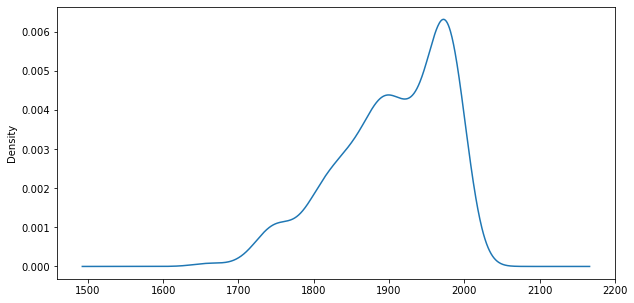

In [40]:
data["duration"].plot(kind='kde', figsize=(10,5))

### Deuxième exemple de visualisation : écart avec le premier

<AxesSubplot:>

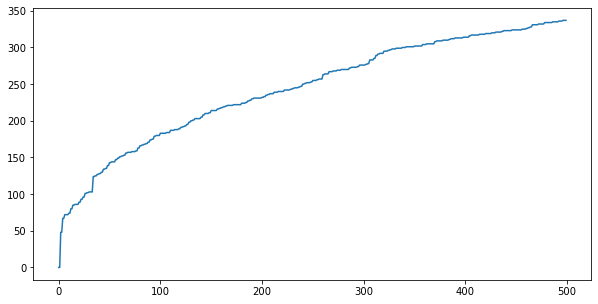

In [41]:
data["time_gap"].dt.total_seconds().plot(figsize=(10,5))

### Troisième exemple de visualisation : histogramme des performances (labels FFA)

<AxesSubplot:>

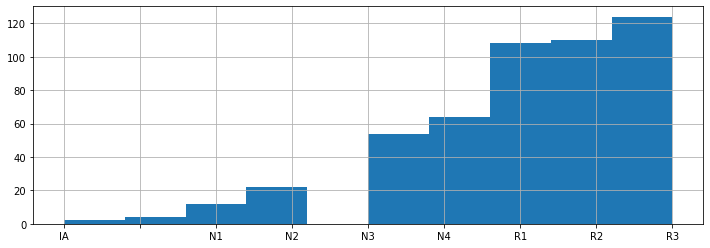

In [42]:
data["Performance"].hist(figsize=(12,4))

<AxesSubplot:>

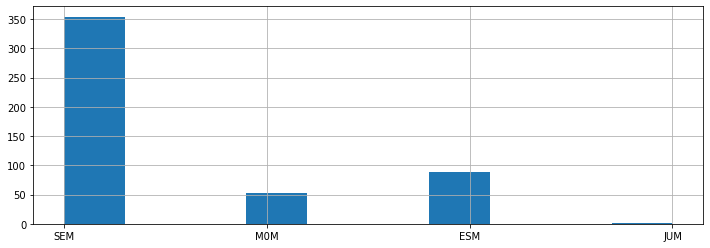

In [43]:
data["Catégorie"].hist(figsize=(12,4))

### Exemple output en csv

In [44]:
#data=data.drop("Club", axis=1)
data.to_csv("France2022_10KM_TCM.csv", index=False)